# Practical 2 : Generative and Discriminative Models


In this practical, we will compare the Naïve Bayes Classifier (NBC) and Logistic Regression on several
datasets. As part of the practical you should read briefly the following paper:



**On Discriminative vs. Generative classifiers: A comparison of logistic regression
and naive Bayes**  
*Andrew Y. Ng and Michael I. Jordan*  
Advances in Neural Information Processing Systems (NIPS) 2001.

The paper is available on OLAT. 

You should read the Introduction and the Experiments sections. The goal of this practical is
to qualitatively reproduce some of the experimental results in this paper. You are strongly
encouraged to read the rest of the paper, which is rather short and straightforward to read,
though some of you may want to skip the formal proofs.

## Naïve Bayes Classifier (NBC)

You should implement a Naïve Bayes Classifier from scartch using NumPy. To keep your code tidy,
we recommend implementing it as a class. 
The classifier should be able to handle binary and continuous features. 
To earn the bonus points, the classifier should be able to handle categorical features as well. 
Suppose the data has 3
different features, the first being binary, the second being continuous and the third being categorical. Write an implementation that you can initialise as follows:

    nbc = NBC(feature_types=['b', 'r', 'c'])

Along the lines of classifiers provided in sklearn, you want to implement two more functions,
**fit** and **predict**. 
Recall the joint distribution of a generative model: $p(\mathbf{x}, y \mid \theta, \pi) = p(y \mid \pi) \cdot p(\mathbf{x} \mid y, \theta)$.
The **fit** function is to estimate all the parameters ($\theta$ and $\pi$) of the NBC, i.e., train the classifier. The **predict** function is to compute the probabilities that the new input belongs to all classes and
then return the class that has the largest probability, i.e., make the prediction.

    nbc.fit(X_train, y_train)
    ypredicted = nbc.predict(X_test)
    test_accuracy = np.mean(ypredicted == ytest)

Here we import the libraries. 

In [1]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (10., 10.)

import pickle as cp
import matplotlib.pyplot as plt
import numpy as np

### Class-conditional distributions

Before implementing NBC, we first implement the class-conditional distributions $p(\mathbf{x} \mid y, \theta)$. Your implementation should have two functions: **estimate** and **get_log_probability**. 

- The **estimate** function takes data as input and models the data using some distribution $p(x \mid \theta)$, where $\theta$ is the parameters of this distribution. The function estimates the parameters $\theta$ using maximum likelihood estimators (MLE). 
For example, in the case of continuous features, we use the Gaussian distribution to model the data. The estimate function will find the parameters $\mu$ and $\sigma$ for the Gaussian distribution with respect to the input data. 

- The **get_log_probability** function takes as input a new data point $x_{new}$ and returns the log of $p(x_{new} \mid \theta)$. For the Gaussian distribution, the function get_probability will return $\mathcal{N}(x_{new} \mid \mu, \sigma)$. 

For different types of features, you need to use different distributions.
You can import statistic libraries (e.g., `scipy.stats`) for the implementation of the distributions. 

- For **continuous features**: Use Gaussian distribution
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
- For **binary features**: Use Bernoulli distribution 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bernoulli.html
- For **categorical features**: Use Multinoulli distribution (The multinoulli distribution is a special case of the multinomial distribution, where the number of trials is 1)
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multinomial.html



**Implementation Issues:**
- The probabilities can be very small. To avoid underflow issues, you should compute the log of the probabilities. Read more: (Mur) Chapter 3.5.3 / Lecture Notes
- The variance for Gaussian distributions should never be exactly 0, so in
case your calculated variance is 0, you may want to set it to a small value such as 1e − 6. This is to ensure that your code never encounters division by zero or
taking logarithms of 0 errors. 
For this practical, please set the small value to 1e-6.
- Laplace/Additive smoothing: You want to ensure that the estimates for the parameter for the Bernoulli and Multinoulli random variables is never exactly 0 or 1. For this reason you should consider using Laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing).
For this practical, please set alpha to 1.
- We will check the correctness of your implementation using the tests below.
- For simplicity, you can assume the data values for binary features are integers from {0,1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.


In [2]:
from scipy.stats import norm, bernoulli, multinomial

ALPHA = 1.0 # for additive smoothing

# Distribution for continuous features
class ContFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Gaussian distribution 
        # so that it best describes the input data X
        self.mu = np.mean(X)
        self.sigma = np.std(X)
        if self.sigma == 0:
            self.sigma = 1e-6  # to prevent division by zero

    def get_log_probability(self, X_new):
        # TODO: return the log of the density values for the input values X_new
        return norm.logpdf(X_new, self.mu, self.sigma)

# Distribution for binary features
class BinFeatureParam:
    def estimate(self, X):
        # TODO: Estimate the parameters for the Bernoulli distribution 
        # so that it best describes the input data X
        self.p = (np.sum(X) + ALPHA) / (len(X) + 2 * ALPHA)

    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        return bernoulli.logpmf(X_new, self.p)

# Distribution for categorical features
class CatFeatureParam:
    
    # we need to know the number of categories for the categorical feature
    def __init__(self, num_of_categories):
        self._num_of_categories = num_of_categories
    
    def estimate(self, X):
        # TODO: Estimate the parameters for the Multinoulli distribution 
        # so that it best describes the input data X
        counts = np.bincount(X, minlength=self._num_of_categories)
        self.probs = (counts + ALPHA) / (len(X) + ALPHA * self._num_of_categories)
        
    def get_log_probability(self, X_new):
        # TODO: return the log of the probability values for the input values X_new
        log_prob = np.zeros(len(X_new))
        for i in range(len(X_new)):
            if X_new[i] < self._num_of_categories:
                log_prob[i] = np.log(self.probs[X_new[i]])
            else:
                log_prob[i] = -np.inf  # Assigning a very low probability if the category is out of bounds
        return log_prob

**Tests:**
    
We will use the code below to test the correctness of your code.

In [3]:
# continuous features

X = np.array([2.70508547,2.10499698,1.76019132,3.42016431,3.47037973,3.67435061,1.84749286,4.3388506,2.27818252,4.65165335])

param = ContFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3]))
print(probs)

[-5.64670664 -3.02757918 -1.44567455 -0.90099277]


In [4]:
# binary features

X = np.array([0,0,1,1,0,1,0,1,1,1])

param = BinFeatureParam()
param.estimate(X)
probs = param.get_log_probability(np.array([0,1]))
print(probs)

[-0.87546874 -0.5389965 ]


In [5]:
# categorical features (bonus task)

X = np.array([0,6,5,4,0,6,6,4,1,1,2,3,8,8,1,6,4,9,0,2,2,3,8,0,2])

param = CatFeatureParam(num_of_categories=10)
param.estimate(X)
probs = param.get_log_probability(np.array([0,1,2,3,4,5,6,7,8,9]))
print(probs)

[-1.94591015 -2.1690537  -1.94591015 -2.45673577 -2.1690537  -2.86220088
 -1.94591015 -3.55534806 -2.1690537  -2.86220088]


### Implement NBC

We are now ready to implement NBC. We follow the structure of models in scikit-learn. We implement NBC as a class with functions **init**, **fit** and **predict**.
The **init** function takes as input the types of features and initialise the classifier. The **fit** function takes the training data as input and estimates the parameters. The **predict** function predicts the label for the input data. 

**Implementation Issues:**
- You should use matrix operations rather than loops. In general, loops over classes or features are OK, but loops over the rows of data are not a good idea.
- The probabilities can be very small. To avoid underflow issues, you should do the calculations in log space. Read more: (Mur) Chapter 3.5.3 / Lecture Note
- For simplicity, you can assume the data values for binary features are integers from {0, 1} and the data for a categorical feature with M categories are integers from {0, ..., M-1}.
- Fell free to add auxiliary functions or change the parameters of the functions. If you change the parameters of the functions, make sure you change the tests accordingly, so we can test your code.

In [6]:
# Your task is to implement the three functions of NBC. 

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    def __init__(self, feature_types=[]):
        self.feature_types = feature_types
        self.params = []
        self.class_priors = []

        
    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        classes = np.unique(y)
        self.class_priors = np.array([np.log(np.mean(y == c)) for c in classes])
        self.params = {f_type: [[] for _ in classes] for f_type in self.feature_types}

        # Estimate parameters for each feature for each class
        for f_idx, f_type in enumerate(self.feature_types):
            if f_type == 'b':
                param_class = BinFeatureParam
            elif f_type == 'r':
                param_class = ContFeatureParam
            elif f_type == 'c':
                num_categories = len(np.unique(X[:, f_idx]))
                param_class = lambda: CatFeatureParam(num_categories)

            for c_idx, c in enumerate(classes):
                idx = np.where(y == c)
                param_instance = param_class()
                param_instance.estimate(X[idx, f_idx].flatten())
                self.params[f_type][c_idx].append(param_instance)
                
                
    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        num_classes = len(self.class_priors)
        log_probs = np.zeros((X.shape[0], num_classes))
        for i in range(num_classes):
            for j, f_type in enumerate(self.feature_types):
                log_probs[:, i] += self.params[f_type][i][j].get_log_probability(X[:, j])
            log_probs[:, i] += self.class_priors[i]

        return np.argmax(log_probs, axis=1)

**Tests**

We will use the code below to check your code.

In [7]:
# All features of the iris dataset are continuous.

from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris['data'], iris['target']

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc_iris = NBC(feature_types=['r', 'r', 'r', 'r'])
nbc_iris.fit(Xtrain, ytrain)
yhat = nbc_iris.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 90%
print(yhat)

Accuracy: 0.9333333333333333
[2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [8]:
# All features of this dataset are binary
import pandas as pd
data = pd.read_csv('./datasets/binary_test.csv', header=None)
data = data.to_numpy()

X = data[:,1:]
y = data[:,0]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['b'] * 16)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 85%
print(yhat)

Accuracy: 0.8723404255319149
[1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0
 0 0 1 0 0 0 0 1 1 0]


In [9]:
# All features of this dataset are categorical (bonus task)

data = pd.read_csv('./datasets/categorical_test.csv', header=None)
data = data.to_numpy()

X = data[:,:-1]
y = data[:,-1]

N, D = X.shape
Ntrain = int(0.8 * N)
Xtrain = X[:Ntrain]
ytrain = y[:Ntrain]
Xtest = X[Ntrain:]
ytest = y[Ntrain:]


nbc = NBC(feature_types=['c'] * 9)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print("Accuracy:", test_accuracy) # should be larger than 65%
print(yhat) 

Accuracy: 0.6896551724137931
[0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 1 0
 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]


## Logistic Regression

For logistic regression, you should use the implementation in scikit-learn. Add the following
line to import the LR model.

In [10]:
from sklearn.linear_model import LogisticRegression

Check the scikit-learn documentation for the Logistic Regression model:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression


## Comparing NBC and LR

### Experiments

The experiment is to compare the classification error of the NBC and LR trained on increasingly larger training datasets. 
Since the datasets are so small, you should do this multiple times and
average the classification error. One run should look as follows:
- Shuffle the data, put 20% aside for testing.
    
    ```N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N)
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    
    ```  


- Train the classifiers with increasingly more data. For example, we can train classifiers with 10%, 20%, ..., 100% of the training data. For each case store the classification errors on the test set of the classifiers.

You may want to repeat this with at least 200 random permutations (possibly as large as 1000)
to average out the test error across the runs. In the end, you will get average test errors as a function of the size of the training data. 
We have written for you the function for making the plots for the experiments. 

In [11]:
# inputs:
#   nbc: Naive Bayes Classifier
#   lr: Logistic Regression Classifier
#   X, y: data
#   num_runs: we need repeat num_runs times and store average results
#   num_splits: we want to compare the two models on increasingly larger training sets.
#               num_splits defines the number of increasing steps. 
# outputs:
#   the arrays of the test errors across the runs of the two classifiers 
def compareNBCvsLR(nbc, lr, X, y, num_runs=200, num_splits=10):
    tst_errs_nbc = np.zeros(num_splits)
    tst_errs_lr = np.zeros(num_splits)

    N, D = X.shape
    split_sizes = np.linspace(0.1, 1.0, num_splits)

    for run in range(num_runs):
        shuffler = np.random.permutation(N)
        Ntrain = int(0.8 * N)
        Xtrain_shuffled = X[shuffler[:Ntrain]]
        ytrain_shuffled = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]

        for i, split_size in enumerate(split_sizes):
            Nsplit = int(split_size * Ntrain)
            Xtrain_split = Xtrain_shuffled[:Nsplit]
            ytrain_split = ytrain_shuffled[:Nsplit]

            # Train NBC
            nbc.fit(Xtrain_split, ytrain_split)
            yhat_nbc = nbc.predict(Xtest)
            tst_errs_nbc[i] += np.mean(yhat_nbc != ytest)

            # Train LR
            lr.fit(Xtrain_split, ytrain_split)
            yhat_lr = lr.predict(Xtest)
            tst_errs_lr[i] += np.mean(yhat_lr != ytest)

    # Average the errors over the number of runs
    tst_errs_nbc /= num_runs
    tst_errs_lr /= num_runs

    return tst_errs_nbc, tst_errs_lr

In [12]:
def makePlot(nbc_perf, lr_perf, title=None, num_splits=10):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.tick_params(axis='both', labelsize=20)

    ax.set_xlabel('Percent of training data used', fontsize=20)
    ax.set_ylabel('Classification Error', fontsize=20)
    if title is not None: ax.set_title(title, fontsize=25)

    xaxis_scale = [(i + 1) * (100/num_splits) for i in range(num_splits)]
    plt.plot(xaxis_scale, nbc_perf, label='Naive Bayes')
    plt.plot(xaxis_scale, lr_perf, label='Logistic Regression', linestyle='dashed')
    
    ax.legend(loc='upper right', fontsize=20)

### Datasets

Tasks: For each dataset,
1. Prepare the data for the two classifiers, e.g., handle missing values and the categorical data. When you handle the categorical data, you should check whether the data is ordinal or not. If the data is ordinal, you should encode the data as integers. If the data is not ordinal, you should encode the data as one-hot vectors.
2. Show the first 5 rows of the prepared data
3. Compare the two classifiers on the dataset and generate the plots

The grading will be based on whether the data is correctly prepared and the plots are generated without errors. The grading will not be based on the performance of the classifiers and whether the plots are the same as in the paper. 

**Dataset 1: Iris Dataset**

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

First 5 rows of the Iris dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


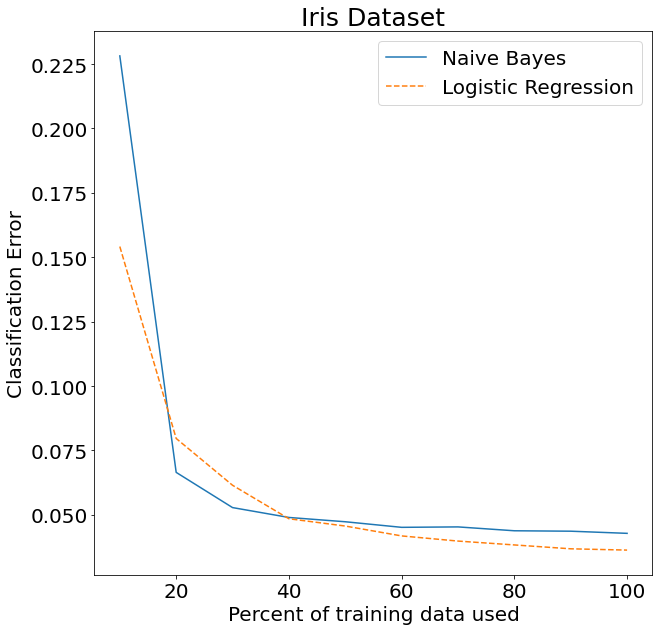

In [13]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris['data']
y = iris['target']

# Convert to DataFrame for easier viewing
df_iris = pd.DataFrame(X, columns=iris['feature_names'])
print("First 5 rows of the Iris dataset:")
print(df_iris.head())

# Prepare the NBC and LR classifiers
nbc = NBC(feature_types=['r', 'r', 'r', 'r'])
lr = LogisticRegression(max_iter=200)

# Compare the classifiers and generate plots
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, X, y)
makePlot(tst_errs_nbc, tst_errs_lr, title='Iris Dataset', num_splits=10)

**Dataset 2: Voting Dataset**

https://archive.ics.uci.edu/ml/datasets/congressional+voting+records

The logistic regression line meets the naive bayes line early in the plot. 

First 5 rows of the Voting Dataset:
   handicapped-infants_n  handicapped-infants_y  water-project-cost-sharing_n  \
0                    1.0                    0.0                           0.0   
1                    1.0                    0.0                           0.0   
2                    1.0                    0.0                           0.0   
3                    1.0                    0.0                           0.0   
4                    0.0                    1.0                           0.0   

   water-project-cost-sharing_y  adoption-of-the-budget-resolution_n  \
0                           1.0                                  1.0   
1                           1.0                                  1.0   
2                           1.0                                  0.0   
3                           1.0                                  0.0   
4                           1.0                                  0.0   

   adoption-of-the-budget-resolution_y  phys

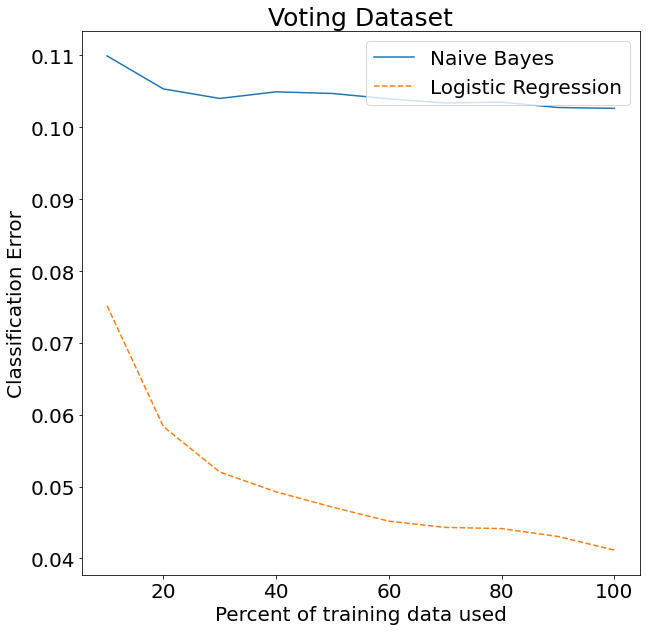

In [14]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Load the dataset
voting = pd.read_csv('./datasets/voting.csv')

# Impute missing values with the most frequent value (mode)
for column in voting.columns[1:]:  # Skip the label column
    mode_value = voting[column].mode()[0]
    voting[column] = voting[column].fillna(mode_value)

# Instantiate the encoders
onehot_encoder = OneHotEncoder(sparse=False)
label_encoder = LabelEncoder()

# One-hot encode the features (independent variables)
voting_features = voting.drop('label', axis=1)
voting_features_encoded = onehot_encoder.fit_transform(voting_features)

# Label encode the target variable
voting_labels = label_encoder.fit_transform(voting['label'])

# Convert the encoded features back to a DataFrame
feature_names = onehot_encoder.get_feature_names_out(voting.columns[1:])
voting_features_encoded_df = pd.DataFrame(voting_features_encoded, columns=feature_names)

# Show the first 5 rows of the prepared data
print("First 5 rows of the Voting Dataset:")
print(voting_features_encoded_df.head())

# Prepare the data for the classifiers
X = voting_features_encoded
y = voting_labels

# Prepare the classifiers
nbc = NBC(feature_types=['b'] * X.shape[1])  # all features are binary after one-hot encoding
lr = LogisticRegression(max_iter=200)

# Compare the classifiers and generate plots
tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, X, y)
makePlot(tst_errs_nbc, tst_errs_lr, title='Voting Dataset', num_splits=10)


**Dataset 3: Breast Cancer Dataset (Bonus Tasks)**

https://archive.ics.uci.edu/ml/datasets/breast+cancer

The dataset has continues, binary and categorical features. It also has missing values.

Hints: You can precompute the size of the domains of the categorical features.

First 5 rows of the Breast Cancer Dataset:
   Class  age  menopause  tumor-size  inv-nodes  node-caps  deg-malig  breast  \
0      0    1          2           6          0          0          3       0   
1      0    2          2           4          0          0          2       1   
2      0    2          2           4          0          0          2       0   
3      0    4          1           3          0          0          2       1   
4      0    2          2           0          0          0          2       1   

   irradiat  breast-quad_central  breast-quad_left_low  breast-quad_left_up  \
0         0                  0.0                   1.0                  0.0   
1         0                  0.0                   0.0                  0.0   
2         0                  0.0                   1.0                  0.0   
3         0                  0.0                   0.0                  1.0   
4         0                  0.0                   0.0                  0.0

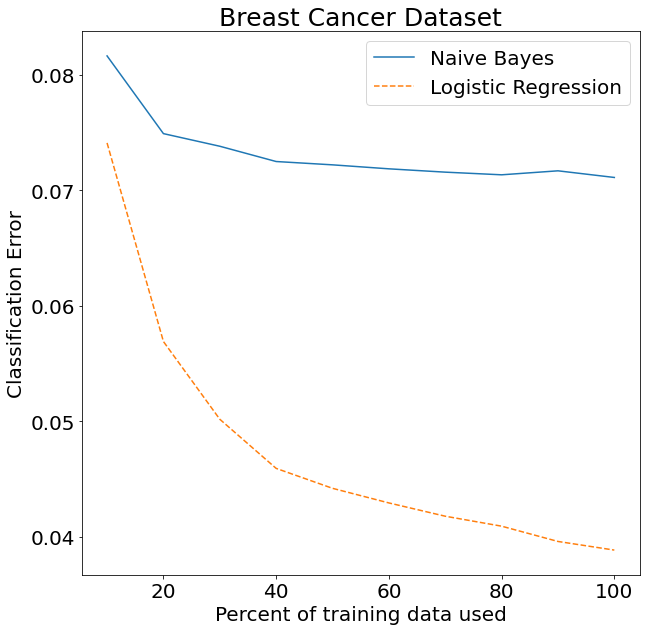

In [15]:
from sklearn.impute import SimpleImputer

cancer = pd.read_csv('./datasets/breast-cancer.csv')

imputer = SimpleImputer(missing_values='?', strategy='most_frequent')
cancer[['node-caps', 'breast-quad']] = imputer.fit_transform(cancer[['node-caps', 'breast-quad']])

label_encoder = LabelEncoder()
cancer['Class'] = label_encoder.fit_transform(cancer['Class'])
cancer['breast'] = label_encoder.fit_transform(cancer['breast'])
cancer['irradiat'] = label_encoder.fit_transform(cancer['irradiat'])
cancer['node-caps'] = label_encoder.fit_transform(cancer['node-caps'])

age_mapping = {'20-29': 0, '30-39': 1, '40-49': 2, '50-59': 3, '60-69': 4, '70-79': 5}
cancer['age'] = cancer['age'].map(age_mapping)

onehot_encoder = OneHotEncoder(sparse=False)
menopause_encoded = onehot_encoder.fit_transform(cancer[['menopause']])

menopause_mapping = {'lt40': 0, 'ge40': 1, 'premeno': 2}
tumor_size_mapping = {'0-4': 0, '5-9': 1, '10-14': 2, '15-19': 3, '20-24': 4, '25-29': 5,
                      '30-34': 6, '35-39': 7, '40-44': 8, '45-49': 9, '50-54': 10}
inv_nodes_mapping = {'0-2': 0, '3-5': 1, '6-8': 2, '9-11': 3, '12-14': 4, '15-17': 5, '24-26': 6}

cancer['menopause'] = cancer['menopause'].map(menopause_mapping)
cancer['tumor-size'] = cancer['tumor-size'].map(tumor_size_mapping)
cancer['inv-nodes'] = cancer['inv-nodes'].map(inv_nodes_mapping)

onehot_encoder = OneHotEncoder(sparse=False)
breast_quad_encoded = onehot_encoder.fit_transform(cancer[['breast-quad']])

breast_quad_encoded_df = pd.DataFrame(breast_quad_encoded, columns=onehot_encoder.get_feature_names_out(['breast-quad']))
cancer_encoded = pd.concat([cancer.drop('breast-quad', axis=1), breast_quad_encoded_df], axis=1)

class NBC:
    # Inputs:
    #   feature_types: the array of the types of the features, e.g., feature_types=['b', 'r', 'c']
    #   domain_sizes: the array of the domain sizes for the categorical features
    def __init__(self, feature_types=[], domain_sizes=None):
        self.feature_types = feature_types
        self.domain_sizes = domain_sizes if domain_sizes is not None else []
        self.params = []
        self.class_priors = []

    # The function uses the input data to estimate all the parameters of the NBC
    def fit(self, X, y):
        classes = np.unique(y)
        self.class_priors = np.array([np.log(np.mean(y == c)) for c in classes])
        self.params = {f_type: [[] for _ in classes] for f_type in self.feature_types}

        # Estimate parameters for each feature for each class
        for f_idx, (f_type, domain_size) in enumerate(zip(self.feature_types, self.domain_sizes)):
            if f_type == 'b':
                param_class = BinFeatureParam
            elif f_type == 'r':
                param_class = ContFeatureParam
            elif f_type == 'c':
                param_class = lambda: CatFeatureParam(domain_size)

            for c_idx, c in enumerate(classes):
                idx = np.where(y == c)
                param_instance = param_class()
                param_instance.estimate(X[idx, f_idx].flatten())
                self.params[f_type][c_idx].append(param_instance)

    # The function takes the data X as input, and predicts the class for the data
    def predict(self, X):
        num_classes = len(self.class_priors)
        log_probs = np.zeros((X.shape[0], num_classes))
        for i in range(num_classes):
            for j, f_type in enumerate(self.feature_types):
                log_probs[:, i] += self.params[f_type][i][j].get_log_probability(X[:, j])
            log_probs[:, i] += self.class_priors[i]

        return np.argmax(log_probs, axis=1)

feature_types = ['b'] * (cancer_encoded.shape[1] - 1)  # excluding the target variable
domain_sizes = [len(cancer_encoded[column].unique()) for column in cancer_encoded.columns if column != 'Class']

print("First 5 rows of the Breast Cancer Dataset:")
print(cancer_encoded.head())

nbc = NBC(feature_types=feature_types, domain_sizes=domain_sizes)
lr = LogisticRegression(max_iter=200)

tst_errs_nbc, tst_errs_lr = compareNBCvsLR(nbc, lr, X, y)
makePlot(tst_errs_nbc, tst_errs_lr, title='Breast Cancer Dataset', num_splits=10)